In [319]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from WallWorld import WallWorld
from DqnAgentNewDims import DqnAgentNewDims
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

if __name__ == "__main__":

    # Config
    max_steps=500_000

    # WallWorld
    render_mode=None
    size=7
    agentSpawn = None
    maxSteps=200
    stepLoss=0
    chestSpawnCoordinates=np.array([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6],
                                    [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6],
                                    [2, 0], [2, 1], [2, 2],         [2, 4], [2, 5], [2, 6]])
    wallCoordinates=      np.array([[3, 0], [3, 1], [3, 2],         [3, 4], [3, 5], [3, 6],])
    agentSpawnCoordinates=np.array([[4, 0],                                         [4, 6],
                                    [5, 0],                                         [5, 6],
                                    [6, 0],                                         [6, 6]])
    randomWalls=0
    redChestCoordinates=None
    greenChestCoordinates=None
    keyCoordinates=None
    randomredChests=1
    randomgreenChests=1
    randomkeys=0
    redChestReward=-1 # Don't change this
    greenChestReward=1 # Don't change this
    # Explaination:
    # terminated with 1 reward ---> green chest: 1
    # terminated with 0 reward ---> red chest:  -1
    # truncated                 --> no chest:    0
    
    # Agent
    batch_size=64
    lr=0.001
    gamma=0.95
    epsilon_start=1
    epsilon_min=0.05
    epsilon_decay=200_000 # 50_000 at 3000 episodes
    tau=0.0005 # Was 0.005
    replayBuffer=100_000

    env = WallWorld(render_mode=None,
                    size=size, agentSpawn=agentSpawn,
                    stepLoss=stepLoss, maxSteps=maxSteps,
                    wallCoordinates=wallCoordinates,
                    randomWalls=randomWalls,
                    redChestCoordinates=redChestCoordinates,
                    greenChestCoordinates=greenChestCoordinates,
                    keyCoordinates=keyCoordinates,
                    redChestReward=redChestReward,
                    greenChestReward=greenChestReward,
                    randomredChests=randomredChests,
                    randomgreenChests=randomgreenChests,
                    randomkeys=randomkeys,
                    agentSpawnCoordinates=agentSpawnCoordinates,
                    chestSpawnCoordinates=chestSpawnCoordinates,
                    newDims=True)
    observation, _ = env.reset()
    agent = DqnAgentNewDims(env.action_space, observation,
        batch_size=batch_size,
        lr=lr,
        gamma=gamma,
        epsilon_start=epsilon_start,
        epsilon_min=epsilon_min,
        epsilon_decay=epsilon_decay,
        tau=tau,
        replayBuffer=replayBuffer)
    
    maxSteps = 30 #????
    show_env = WallWorld(render_mode="human",
                    size=size, agentSpawn=agentSpawn,
                    stepLoss=stepLoss, maxSteps=maxSteps,
                    wallCoordinates=wallCoordinates,
                    randomWalls=randomWalls,
                    redChestCoordinates=redChestCoordinates,
                    greenChestCoordinates=greenChestCoordinates,
                    keyCoordinates=keyCoordinates,
                    redChestReward=redChestReward,
                    greenChestReward=greenChestReward,
                    randomredChests=randomredChests,
                    randomgreenChests=randomgreenChests,
                    randomkeys=randomkeys,
                    agentSpawnCoordinates=agentSpawnCoordinates,
                    chestSpawnCoordinates=chestSpawnCoordinates,
                    newDims=True)

    modelNames = ["r00_g10_1500k",
              "r01_g10_1500k",
              "r02_g10_1500k",
              "r03_g10_1500k",
              "r04_g10_1500k",
              "r05_g10_1500k",
              "r06_g10_1500k",
              "r07_g10_1500k",
              "r08_g10_1500k",
              "r09_g10_1500k",
              "r10_g00_1500k",
              "r10_g01_1500k",
              "r10_g02_1500k",
              "r10_g03_1500k",
              "r10_g04_1500k",
              "r10_g05_1500k",
              "r10_g06_1500k",
              "r10_g07_1500k",
              "r10_g08_1500k",
              "r10_g09_1500k",
              "r10_g10_1500k"]

In [320]:
agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/r03_g10_3000k.pth")

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
actions = agent.predict(state)

def plotState(state):
    image = state.squeeze().numpy().transpose((2, 1, 0))
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
    plt.show()

def printActions(actions):
    action_to_direction = {0: 'Right', 1: 'Down', 2: 'Left', 3: 'Up'}
    for i, action in enumerate(actions[0]):
        print(f"{action_to_direction[i]}: {action:.3f}", end=", ")

printActions(actions)


Model loaded: C:/Projects/public/XAI_Master/models/r03_g10_3000k.pth
Right: 0.574, Down: 0.598, Left: 0.626, Up: 0.628, 

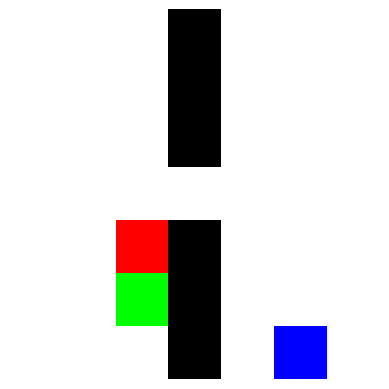

100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


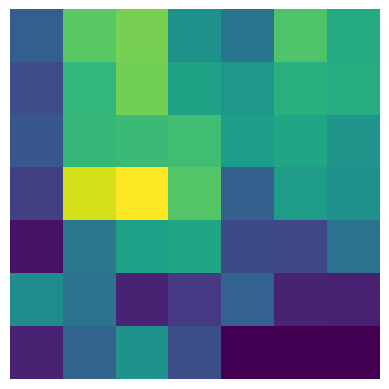

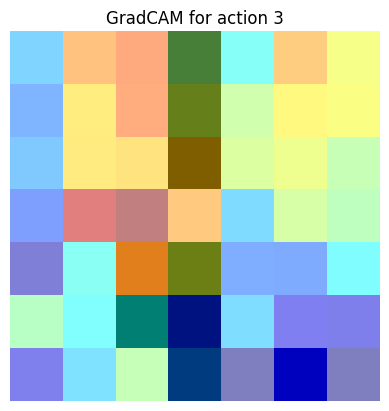

Model outputs: tensor([[0.5743, 0.5976, 0.6259, 0.6282]], grad_fn=<AddmmBackward0>)


In [ ]:
target_layer = agent.policy_net.conv3
action_idx = torch.argmax(actions, dim=1).item()
targets = [ClassifierOutputTarget(action_idx)]

plotState(state)

# Create a GradCAM object with the agent's policy network and target layer
with AblationCAM(model=agent.policy_net, target_layers=[target_layer]) as cam:
    # Generate the CAM
    grayscale_cam = cam(input_tensor=state, targets=targets)
    
    grayscale_cam = grayscale_cam[0, :]#only one image in the batch
    
    original_img = state[0].permute(2, 1, 0).cpu().numpy()

    grayscale_cam = grayscale_cam.transpose(1, 0)

    plt.imshow(original_img, interpolation='nearest')
    plt.imshow(grayscale_cam, interpolation='nearest')
    plt.axis('off')
    plt.show()
    
    # Create the CAM visualization
    visualization = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
    
    # Save or display the visualization
    import matplotlib.pyplot as plt
    plt.imshow(visualization)
    plt.title(f"GradCAM for action {action_idx}")
    plt.axis('off')
    plt.show()
    
    # You can also get the model outputs without redoing inference
    model_outputs = cam.outputs
    print(f"Model outputs: {model_outputs}")